In [52]:
#IMPORTS

import pandas as pd # to read sql data into a pandas dataframe
import psycopg2 # to connect to SQL database
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import missingno as msno
import haversine as hs
from haversine import haversine, Unit

## Preliminary Data Cleaning

In [53]:
#Make data frame from CSV. It's within the parent folder "data"
#so that must be included as well

df_king_county = pd.read_csv('./data/king_county_data_joined.csv')
df_king_county.head()

,date,price,house_id,id,id.1,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,7129300520,1,7129300520,3.0,1.00,1180.0,5650.0,1.0,...,7,1180.0,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0
1,2014-12-09,538000.0,6414100192,2,6414100192,3.0,2.25,2570.0,7242.0,2.0,...,7,2170.0,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0
2,2015-02-25,180000.0,5631500400,3,5631500400,2.0,1.00,770.0,10000.0,1.0,...,6,770.0,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0
3,2014-12-09,604000.0,2487200875,4,2487200875,4.0,3.00,1960.0,5000.0,1.0,...,7,1050.0,910.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0
4,2015-02-18,510000.0,1954400510,5,1954400510,3.0,2.00,1680.0,8080.0,1.0,...,8,1680.0,0.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0


In [54]:
#now I want to clean the data frame a bit
#I remove the id.1 column which is a repeat of the house_id
#and delete the id column which seems irrelevant... (some sort of sales id)

df_king_county = df_king_county.drop(columns=['id.1', 'id'])
#this is commented out because it causes an error once they've been removed

df_king_county.columns

# #Index(['date', 'price', 'house_id', 'bedrooms', 'bathrooms', 'sqft_living',
#        'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
#        'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
#        'lat', 'long', 'sqft_living15', 'sqft_lot15'],
#       dtype='object')


#note that later on it might be good to make "total square foot" and "price per square foot" columms

Index(['date', 'price', 'house_id', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## Variable Types

Now that I know the column heads, I should write a little description of each, mentioning also if they are continuous or categorical

* date: qualitative ordinal

* price: quantitative continuous

* house_id: qualitiative nominal

* bedrooms: quantitative discrete
* bathrooms: quantitative discrete
* sqft_living: quantitative continuous
* sqft_lot: quantitative continuous
* floors: quantitative discrete
* waterfront: qualitative ordinal (0 or 1)
* view: qualitative ordinal
* condition: qualitative ordinal
* grade: qualitative ordinal
* sqft_above: quantitative continuous
* sqft_basement: quantitative continuous
* yr_built: qualitative ordinal
* yr_rennovated: qualitative ordinal
* zipcode: qualitative nominal
* lat: qualitative nominal
* long: qualitative nominal
* sqft_living15: quantitative continuous
* sqft_lot15: quantitative continuous


In [55]:
#EXPLORE THE DATA

#check data types
df_king_county.info()

#I see off the bat something I need to change:
#date should be datetime format (right now it is 'object')

#fortunately column names are all in snake case already

df_king_county.head()


#check the shape of the data
df_king_county.shape

#it has 21597 rows and 21 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   bedrooms       21597 non-null  float64
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  float64
 6   sqft_lot       21597 non-null  float64
 7   floors         21597 non-null  float64
 8   waterfront     19206 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  float64
 13  sqft_basement  21145 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17749 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

(21597, 21)

## Dealing with Duplicates

In [56]:
df_king_county.duplicated().value_counts()

#this is false for 21597 rows which is the total number of rows so there are no duplicates :)

False    21597
Name: count, dtype: int64

## Data Types

In [57]:
#As seen before, we need to change the dates to datetime format

# type(df_king_county['date'][0]) #tells me it is a string

df_king_county['date'] = pd.to_datetime(df_king_county['date'], format='%Y-%m-%d')

type(df_king_county['date'][0]) #now verifies it's the correct type

pandas._libs.tslibs.timestamps.Timestamp

## Unique elements

In [58]:
df_king_county.nunique()

date               372
price             3622
house_id         21420
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      303
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               752
sqft_living15      777
sqft_lot15        8682
dtype: int64

## Missing Values

In [59]:
# display number of missing values per column
df_king_county.isna().sum()

#this reveals that our 4 problem features are 
# "view," "waterfront," "sqft_basement," and "yr_rennovated"

date                0
price               0
house_id            0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

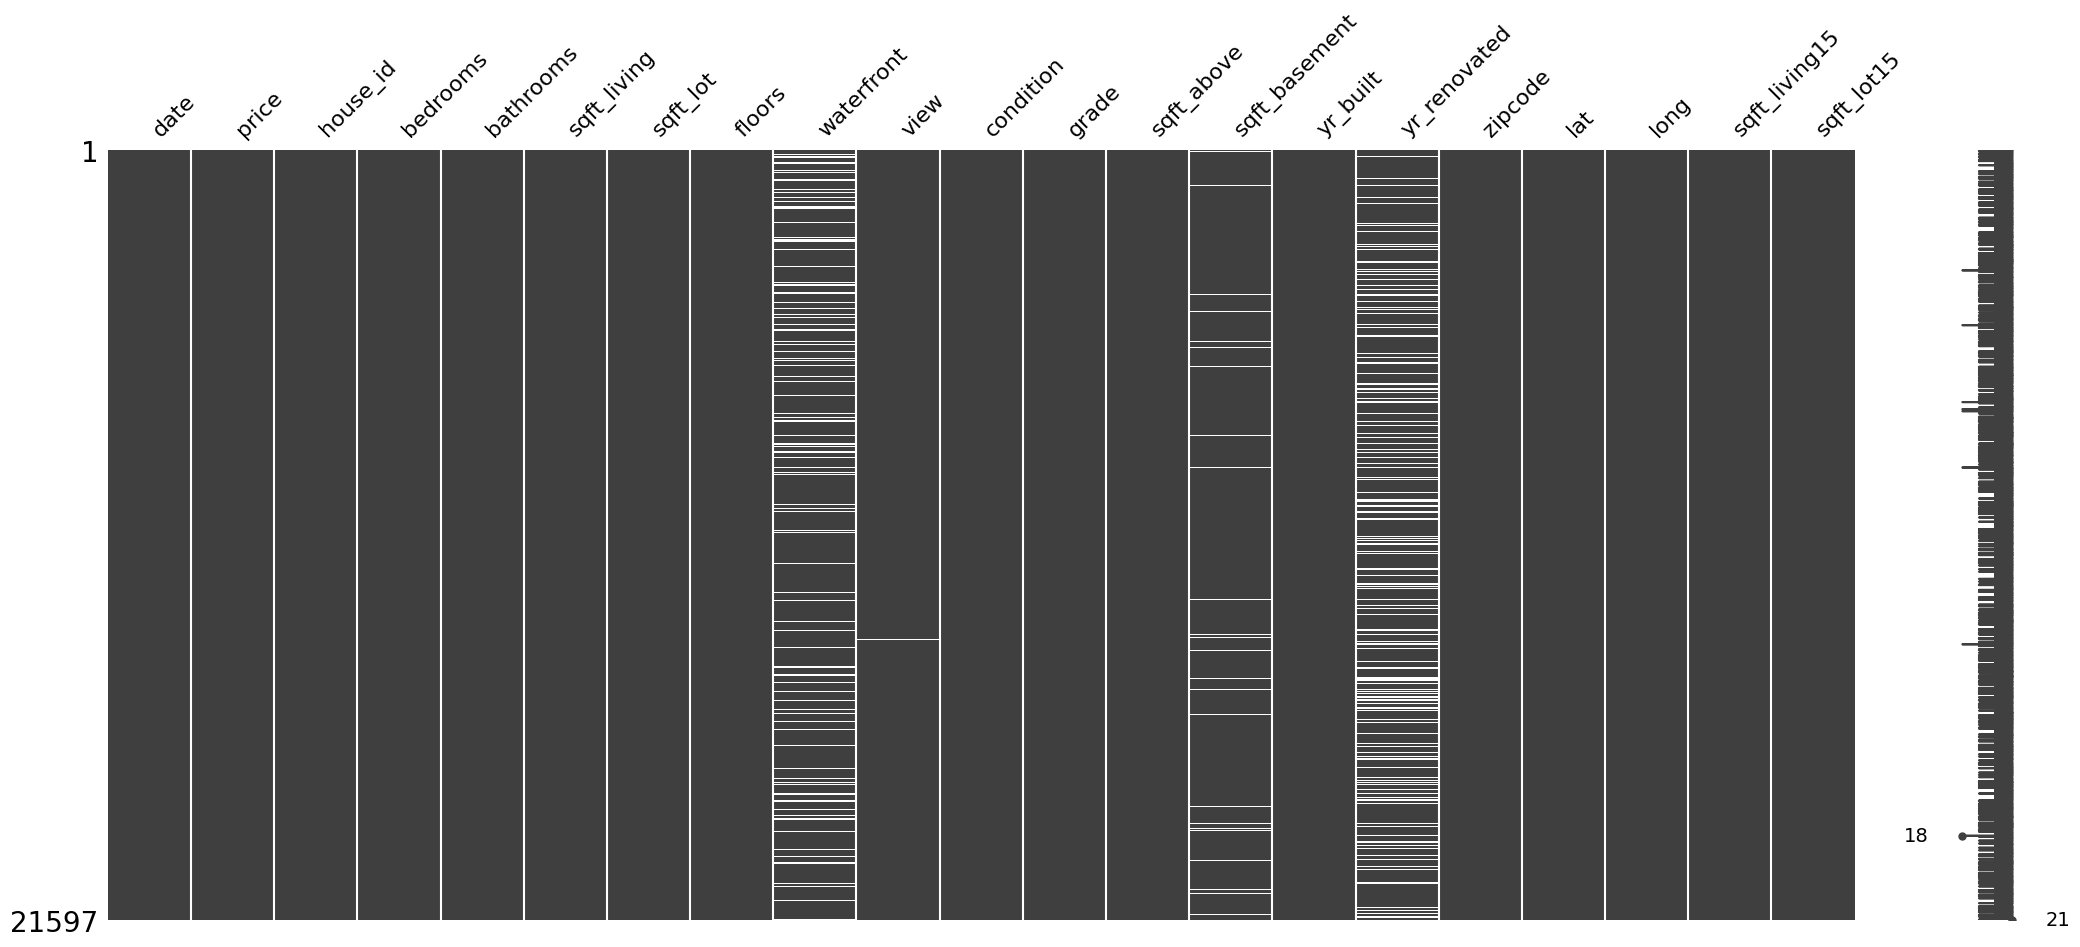

In [60]:
#I might want to see if these missing values are grouped in any way

msno.matrix(df_king_county);

#all i see from this is that it looks like there are consecutive rows of missing values for "view"

## Research Questions and Hypothesis Generation

First I want to make sure that I keep the goals of my client (Nicole Johnson) in mind. These are as follows:
She is a buyer who wants a lively, central neighborhood, middle price range, and to buy within a year

### QUESTION 1:
* Do the houses in Seattle have worse condition on average?
#### Hypothesis 1:
* If a house is in Seattle, it is more likely to have a worse condition.

### QUESTION 2:
* Do the houses in Seattle cost more?
#### Hypothesis 2:
* If a house is in Seattle, it is likely to cost more per square foot.

### QUESTION 3:
* Are the houses in the suburbs more modern?
#### Hypothesis 3:
* If a house is in Seattle, it is more likely to be older.

In [61]:
#Before continuing, I think it's important to create a new column called "price_per_sqft"
#since this will be an important metric

df_king_county['price_per_sqft'] = df_king_county['price'] / df_king_county['sqft_living']




#Furthermore, when thinking about city center, I want to think about a few things.
#First - zip codes in seattle (there are 127 zip codes in the county and 40 in seattle)
#Second - lively, central neighborhoods (consult websites/reddit)


seattle_zip_codes = [98102, 98103, 98107, 98109, 98112, 98115, 98117, 98119, 98125, 98133, 
                     98177, 98105, 98106, 98108, 98112, 98116, 98118, 98122, 98126, 98134, 
                     98136, 98144, 98146, 98178, 98199, 98101, 98104, 98113, 98121, 98141, 
                     98154, 98161, 98165, 98170, 98174, 98175, 98181, 98185, 98190, 98191, 98194]


#now I add a column called "is_in_seattle" to the table which I want to have a True/False value 
#based on the zip codes in this list

df_king_county['is_in_seattle'] = df_king_county['zipcode'].isin(seattle_zip_codes)
df_king_county

#I want to see how much data we have for the city of Seattle to see if it's viable to make use of just that 

df_king_county.value_counts('is_in_seattle')

#this tells me that there are 7531 just in Seattle



is_in_seattle
False    14066
True      7531
Name: count, dtype: int64

## Exploring the Data

Let's start with the CONTINUOUS variables. These include:

* price: quantitative continuous

* sqft_living: quantitative continuous

* sqft_lot: quantitative continuous

* sqft_above: quantitative continuous

* sqft_basement: quantitative continuous

* sqft_living15: quantitative continuous

* sqft_lot15: quantitative continuous

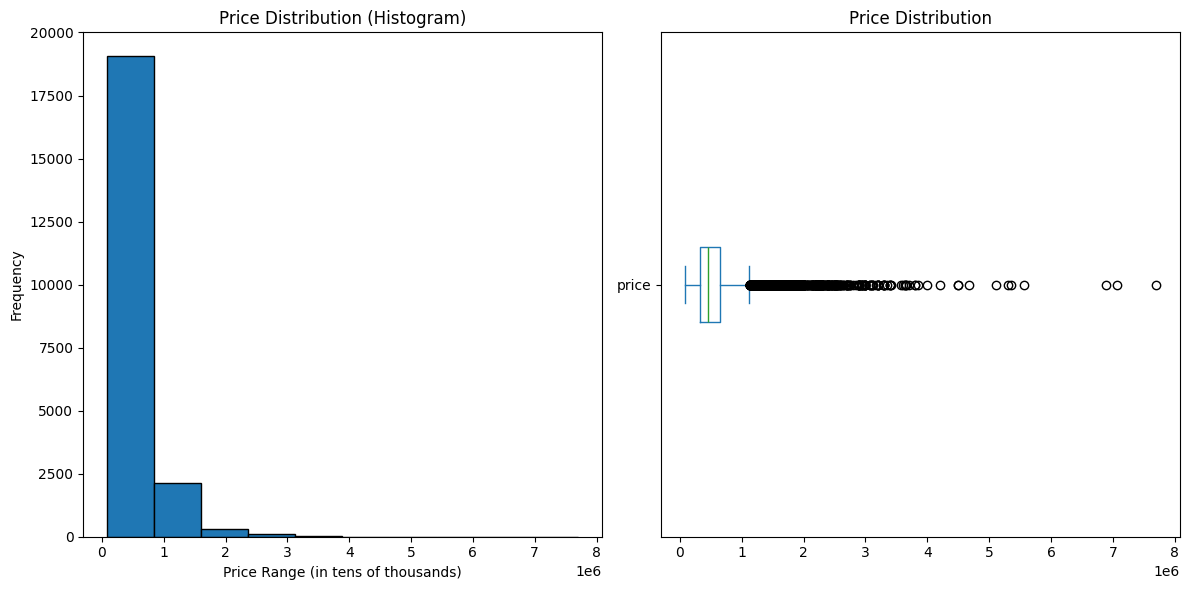

In [62]:
#STARTING WITH PRICE (I will make a histogram and a box plot to look at the data and display side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


#make the histogram which will show on the left (i.e. axis 0)
ax = df_king_county['price'].plot(kind='hist', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Price Range (in tens of thousands)')
axes[0].set_title('Price Distribution (Histogram)')
axes[0].set_ylabel('Frequency')


#make the box plot which will show on the right (i.e. axis 1)
df_king_county['price'].plot(kind='box', vert = False, ax=axes[1])
axes[1].set_title('Price Distribution')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

#These histogram is not so insightful since there are some trailing values at the end


<!-- ## Conclusion: There is more to be gained by looking at the "Price per square foot" colummn -->

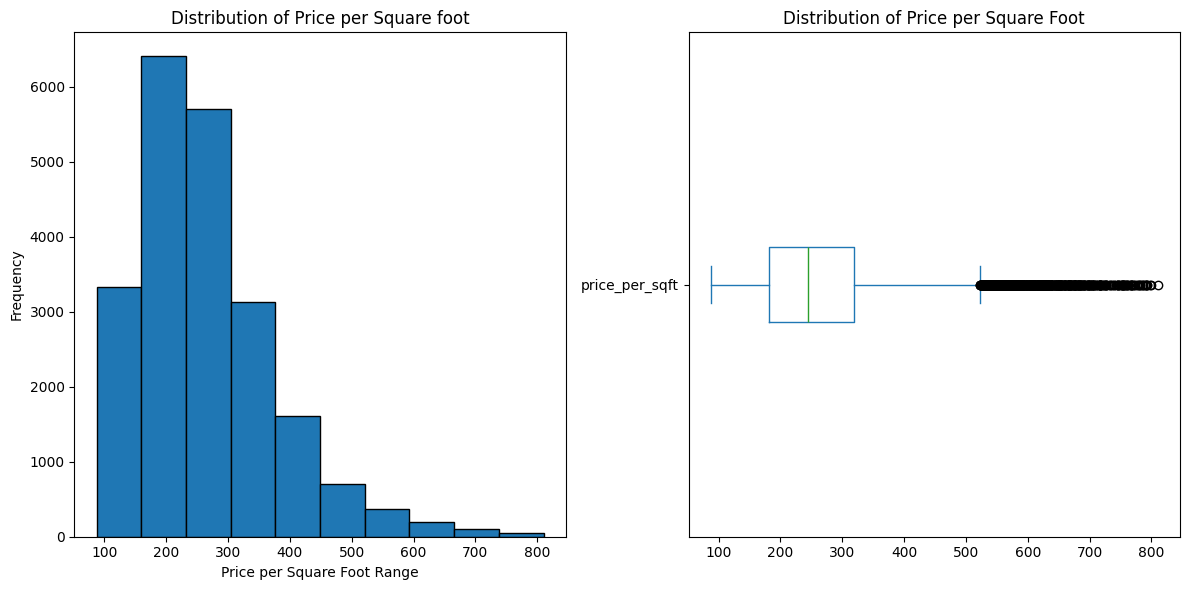

In [63]:
#now I want to do the same thing except with the price per square foot column

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


#make the histogram which will show on the left (i.e. axis 0)
ax = df_king_county['price_per_sqft'].plot(kind='hist', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Price per Square Foot Range')
axes[0].set_title('Distribution of Price per Square foot')
axes[0].set_ylabel('Frequency')


#make the box plot which will show on the right (i.e. axis 1)
df_king_county['price_per_sqft'].plot(kind='box', vert=False, ax=axes[1]) #I make the vertical "false" so that the axes correspond
axes[1].set_title('Distribution of Price per Square Foot')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

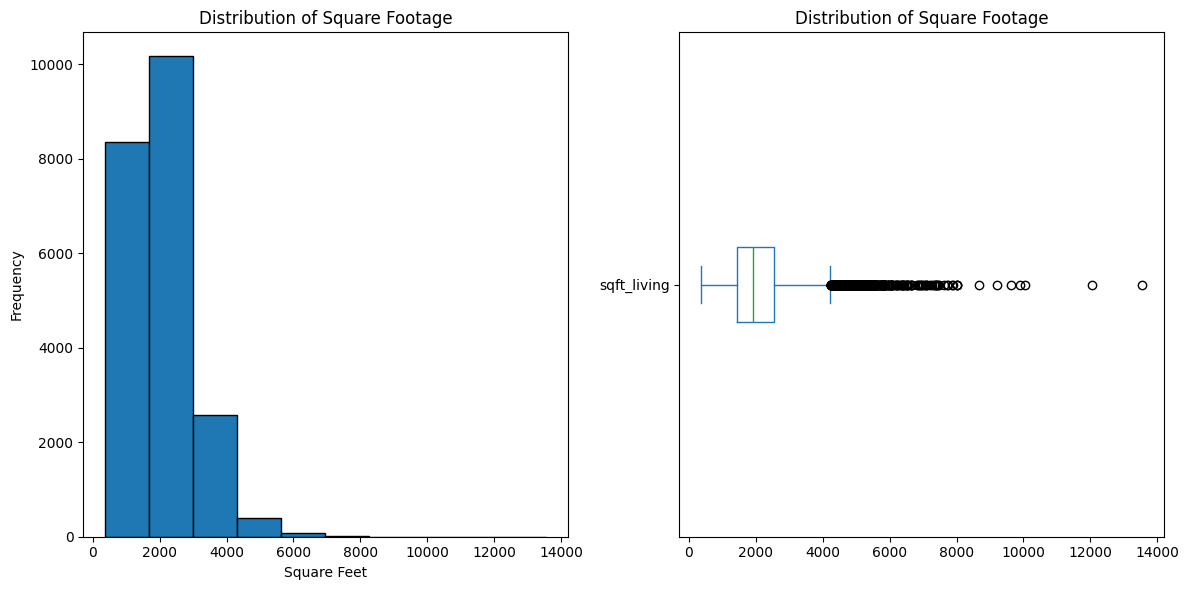

In [64]:
#Now with sqft_living

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


#make the histogram which will show on the left (i.e. axis 0)
ax = df_king_county['sqft_living'].plot(kind='hist', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Square Feet')
axes[0].set_title('Distribution of Square Footage')
axes[0].set_ylabel('Frequency')


#make the box plot which will show on the right (i.e. axis 1)
df_king_county['sqft_living'].plot(kind='box', vert=False, ax=axes[1]) #I make the vertical "false" so that the axes correspond
axes[1].set_title('Distribution of Square Footage')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

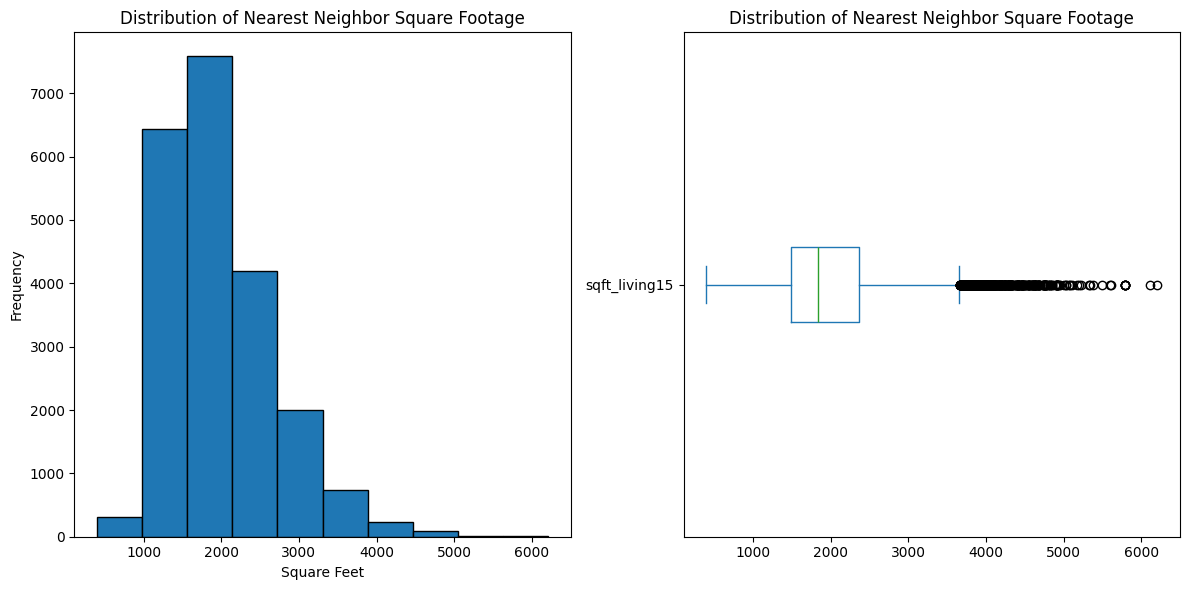

In [65]:
#now for sqft_living15 since this seems like the other one which is most relevant

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


#make the histogram which will show on the left (i.e. axis 0)
ax = df_king_county['sqft_living15'].plot(kind='hist', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Square Feet')
axes[0].set_title('Distribution of Nearest Neighbor Square Footage')
axes[0].set_ylabel('Frequency')


#make the box plot which will show on the right (i.e. axis 1)
df_king_county['sqft_living15'].plot(kind='box', vert=False, ax=axes[1]) #I make the vertical "false" so that the axes correspond
axes[1].set_title('Distribution of Nearest Neighbor Square Footage')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

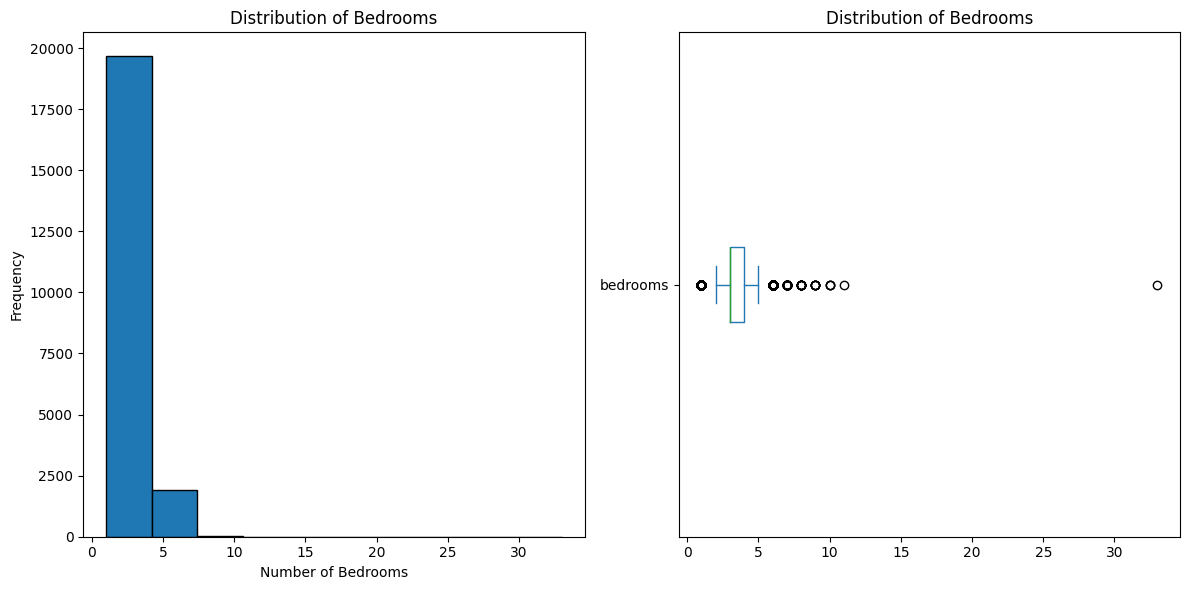

In [66]:
#now for bedrooms since this seems like the other one which is most relevant

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


#make the histogram which will show on the left (i.e. axis 0)
ax = df_king_county['bedrooms'].plot(kind='hist', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Number of Bedrooms')
axes[0].set_title('Distribution of Bedrooms')
axes[0].set_ylabel('Frequency')


#make the box plot which will show on the right (i.e. axis 1)
df_king_county['bedrooms'].plot(kind='box', vert=False, ax=axes[1]) #I make the vertical "false" so that the axes correspond
axes[1].set_title('Distribution of Bedrooms')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Now let's move to CATEGORICAL Variables which it makes sense to examine. These include:

* date: qualitative ordinal
* waterfront: qualitative ordinal (0 or 1)
* view: qualitative ordinal
* condition: qualitative ordinal
* grade: qualitative ordinal
* yr_built: qualitative ordinal
* yr_rennovated: qualitative ordinal
* zipcode: qualitative nominal


Those for which it does not make sense to examine are:
* house_id: qualitative ordinal
* lat: qualitative nominal
* long: qualitative nominal

This is because we can't do much in the way of comparison


We'll start by looking at counts for different values and then also compare different categorical values.

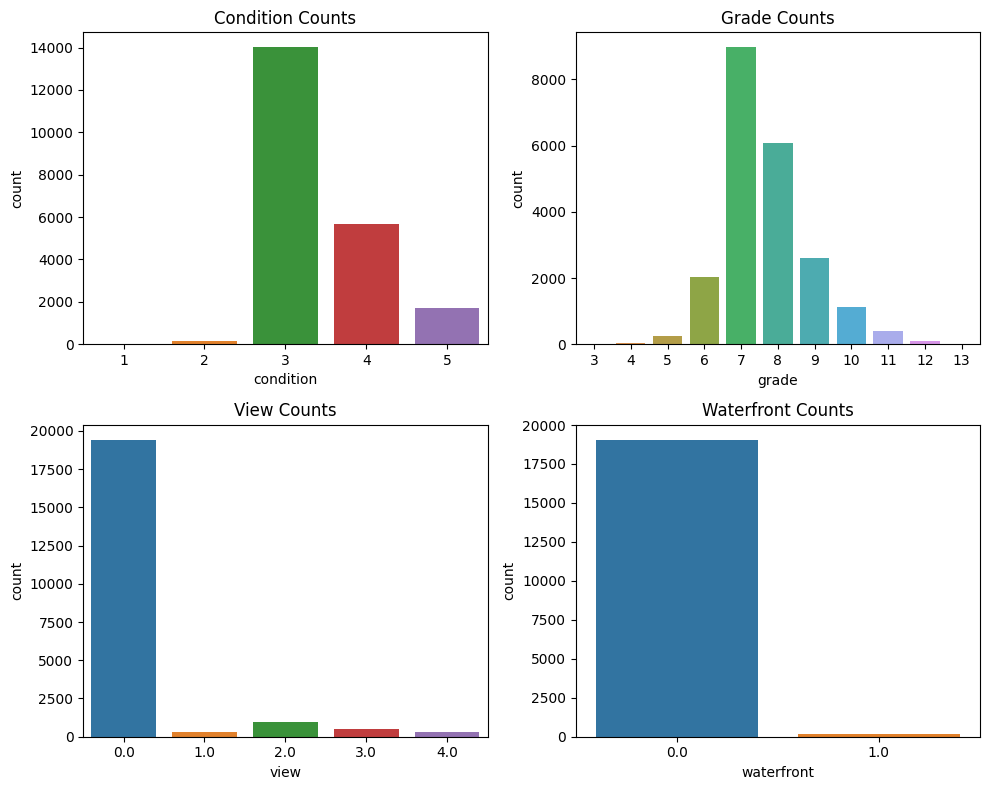

In [67]:
#First we start by inspecting the counts of some of these. I want to lay them all out together on a grid


columns_to_plot = ['condition', 'grade', 'view', 'waterfront']  # Add your desired columns here

# Create a grid of subplots, n rows and 1 column (adjust as needed)
n = len(columns_to_plot)  # Number of count plots you want
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Adjust figsize as needed. Since I'm doing 4 plots, i did 2x2

# Loop through each column to create count plots
for i, column in enumerate(columns_to_plot):
    row = i // 2  # Determine the row (integer division by 2)
    col = i % 2   # Determine the column (modulo 2)
    sns.countplot(x=column, data=df_king_county, ax=axes[row, col])  # Plot on the ith axis
    axes[row, col].set_title(f'{column.capitalize()} Counts')  # Add title to each plot

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


#The above code iterates over creating plots individually each way like seen below:
# sns.countplot(x='view', data=df_king_county)
# plt.title('View Counts');


# sns.countplot(x='condition', data=df_king_county)
# plt.title('Condition Counts');

There are a lot of outliers in the numerical data which I want to tackle. Let's see how many outliers are in each column

In [68]:
# Assuming df_king_county is your DataFrame
outlier_counts = {}

for column in df_king_county.select_dtypes(include='number'):  # Select only numeric columns
    Q1 = df_king_county[column].quantile(0.25)  # 25th percentile
    Q3 = df_king_county[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range

    # Calculate outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_king_county[(df_king_county[column] < lower_bound) | (df_king_county[column] > upper_bound)]

    # Count outliers
    outlier_counts[column] = outliers.shape[0]

# Display the result
print("Number of outliers in each column:")
print(outlier_counts)

Number of outliers in each column:
{'price': 1158, 'house_id': 0, 'bedrooms': 530, 'bathrooms': 561, 'sqft_living': 571, 'sqft_lot': 2419, 'floors': 0, 'waterfront': 146, 'view': 2112, 'condition': 29, 'grade': 1905, 'sqft_above': 610, 'sqft_basement': 484, 'yr_built': 0, 'yr_renovated': 744, 'zipcode': 0, 'lat': 2, 'long': 255, 'sqft_living15': 543, 'sqft_lot15': 2188, 'price_per_sqft': 705}


Results for columns which make sense:

'price': 1158

'bedrooms': 530

'bathrooms': 561

'sqft_living': 571

'sqft_lot': 2419

'condition': 29

'grade': 1905

'price_per_sqft': 705

In [69]:
#How are there so many outliers? Let's get some 5-number summaries as well as unique values and see

# Get all unique values in the 'grade' column
unique_grades = df_king_county['grade'].unique()
print(unique_grades)

df_king_county['grade'].describe()

#Q1 is 7 Q3 is 8 so there is not much span for the outliers



[ 7  6  8 11  9  5 10 12  4  3 13]


count    21597.000000
mean         7.657915
std          1.173200
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

I've determined that because the outliers are in large part a result of the fact that the IQR's are so small, I don't think there is much need 
to clean the data other than to drop the house with 33 bedrooms

In [70]:
index_to_drop = df_king_county[df_king_county['bedrooms'] == 33].index

# Drop the row
df_king_county = df_king_county.drop(index=index_to_drop)


# Hypotheses
## Hypothesis 1

Note that these are based on all of the data and so I will stick with the df_king_county.

Question 1: Does the distance from the city center affect the condition?

Corresponding hypothesis: The closer a house is to the city center, the more likely it is to have a low condition

I want to create a "distance from city center" column based on giving a lat,long pair for "city center" and then computing the distance
using haversine. I will also need to make a 

In [71]:
center_latitude = 47.620564
center_longitude = -122.350616

city_center = (center_latitude, center_longitude)

#the columns which contain the lat and long information of houses are called lat and long. For haversine I need to make tuples

#This makes a new column containing the tuple by zipping the lat and long columns
df_king_county['lat_long_tuple'] = list(zip(df_king_county['lat'], df_king_county['long']))


#now I make a new column which has the distance from the city center calculated via haversine
df_king_county['distance_from_city_center'] = df_king_county['lat_long_tuple'].apply(lambda x: hs.haversine(x, city_center))

# Display the first few rows to check the new column
df_king_county[['lat_long_tuple', 'distance_from_city_center']].head()


,lat_long_tuple,distance_from_city_center
0,"(47.5112, -122.257)",14.043416
1,"(47.721, -122.319)",11.416139
2,"(47.7379, -122.233)",15.740509
3,"(47.5208, -122.393)",11.539974
4,"(47.6168, -122.045)",22.910440


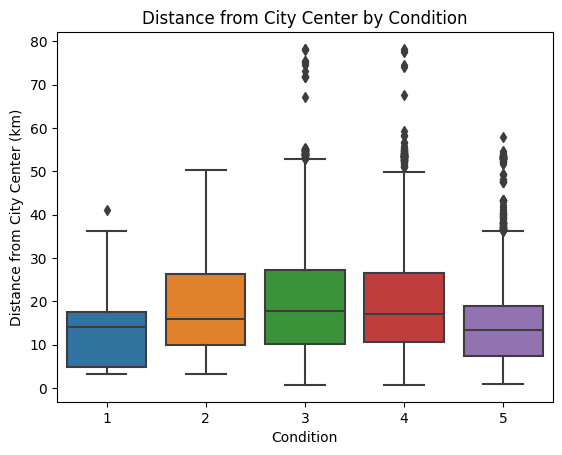

In [72]:
#Now I want to plot. The plan is to group by condition and then see the distribution of distances

sns.boxplot(x='condition', y='distance_from_city_center', data=df_king_county)

# Add labels and title
plt.title('Distance from City Center by Condition')
plt.xlabel('Condition')
plt.ylabel('Distance from City Center (km)')

plt.show()

Visually this indicates that there is not really a correlation between condition and distance. They all have roughly the same
min and median. Conditions 2, 3, and 4 have a slight skew towards further distance, but this is not significant. These findings are
supported by the insignificance of the correlation coefficient found below:

In [73]:
correlation = df_king_county['distance_from_city_center'].corr(df_king_county['condition'])

print(f"Correlation between distance from city center and condition: {correlation}")

Correlation between distance from city center and condition: -0.07236047967463276


## Hypothesis 2

Do the houses in Seattle cost more on average?

Corresponding hypothesis: If a house is in Seattle, it is likely to cost more per square foot than an average house in King County.


For this I think my approach will be to make a sub-data frame which only contains the columns with True in the is_in_seattle column. Then I
will run all of the same statistics on that and compare.


In [85]:
df_king_county

df_seattle = df_king_county[df_king_county['is_in_seattle']] #because this column is Boolean, this will only grab those which are True
                                                            # I verified this worked correctly by checking the shape

#df_king_county['price_per_sqft'].describe()

df_seattle['price_per_sqft'].describe()


count    7530.000000
mean      323.551137
std       112.916819
min        87.647059
25%       242.063492
50%       311.770089
75%       388.598565
max       810.138889
Name: price_per_sqft, dtype: float64

**"Describe" information for king county:**

count    21596.000000

mean       264.137306

std        109.999000

min         87.588235

25%        182.291667

50%        244.626805

75%        318.328353

max        810.138889


**"Describe" information for seattle:**

count    7530.000000

mean      323.551137

std       112.916819

min        87.647059

25%       242.063492

50%       311.770089

75%       388.598565

max       810.138889


Clearly the mean is greater and so is the median!

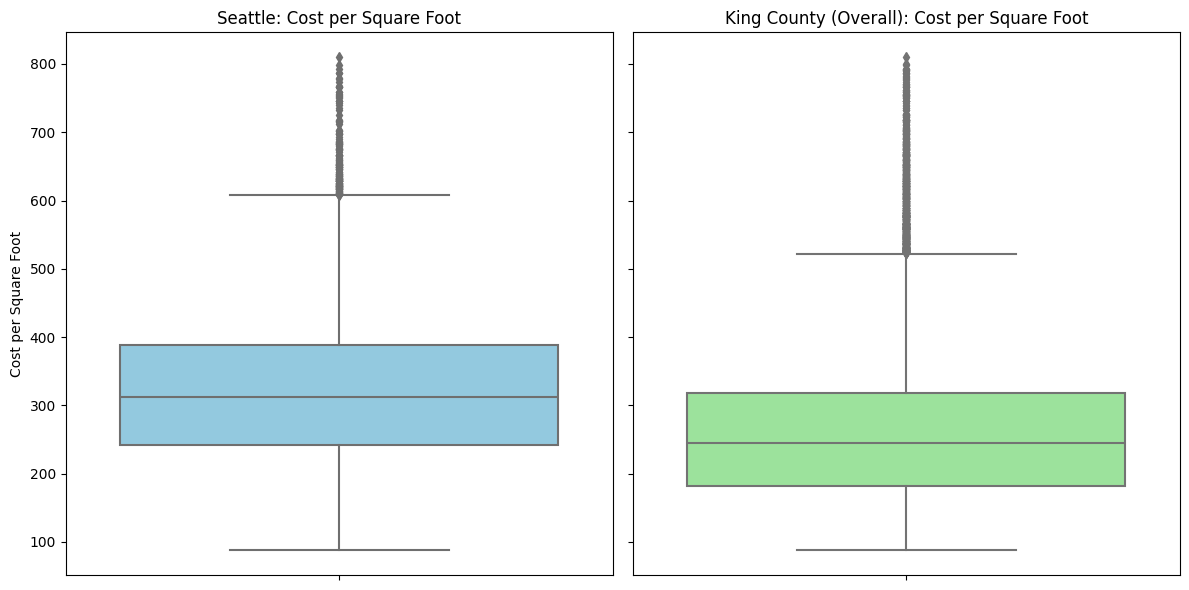

In [87]:
#I want to compare the percent difference in the mean and median as well as compare the distributions of the price per square foot

#Box plot comparisons:

# Create a figure with two subplots (so that they show side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # sharey ensures the y-axis is consistent

# Box plot for Seattle
sns.boxplot(y=df_seattle['price_per_sqft'], ax=axes[0], color='skyblue')
axes[0].set_title('Seattle: Cost per Square Foot')
axes[0].set_ylabel('Cost per Square Foot')

# Box plot for King County
sns.boxplot(y=df_king_county['price_per_sqft'], ax=axes[1], color='lightgreen')
axes[1].set_title('King County (Overall): Cost per Square Foot')
axes[1].set_ylabel('')  # No need for duplicate label

# Add a tight layout
plt.tight_layout()

# Show the plots
plt.show()


In [98]:
median_seattle = 311.770089
mean_seattle = 323.551137

median_king_county = 244.626805
mean_king_county = 264.137306

def percent_difference(x,y):
    return round(((x-y)/y) * 100)
    

print(f'The percent difference between the median price per square foot in all of King County versus ' \
      f'specifically in Seattle is {percent_difference(median_seattle, median_king_county)} percent')


print(f'The percent difference between the mean price per square foot in all of King County versus ' \
      f'specifically in Seattle is {percent_difference(mean_seattle, mean_king_county)} percent')


The percent difference between the median price per square foot in all of King County versus specifically in Seattle is 27 percent
The percent difference between the mean price per square foot in all of King County versus specifically in Seattle is 22 percent


## Hypothesis 3

Question 3: Is having a view correlated with greater square footage?

Corresponding hypothesis: Higher view score is correlated with higher square footage.



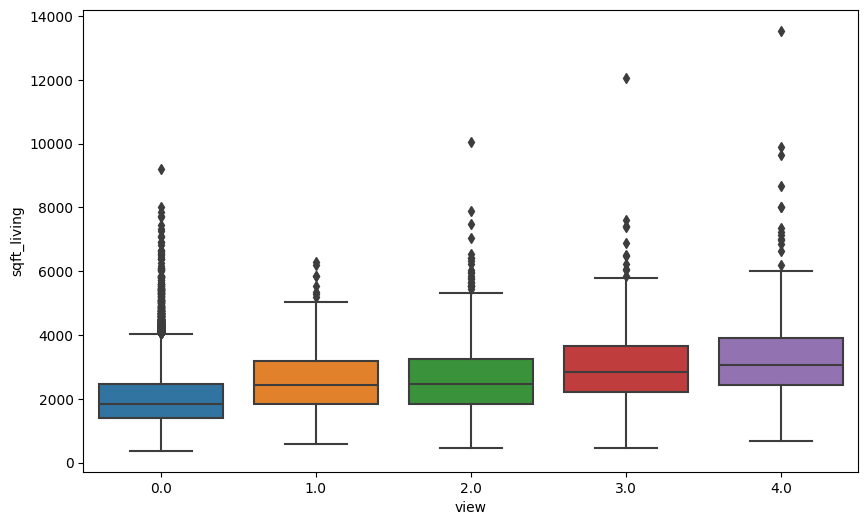

In [102]:
plt.figure(figsize=(10, 6))  # Set figure size
sns.boxplot(x='view', y='sqft_living', data=df_king_county);

In [104]:
correlation_view_sqft = df_king_county['view'].corr(df_king_county['sqft_living'])

print(f"Correlation between view and living space: {correlation_view_sqft}")

#This is .282 which is not really significant

Correlation between view and living space: 0.28252758638749725
